<a href="https://colab.research.google.com/github/sean-halpin/ml_tweepy_proj/blob/main/svm_text_sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [175]:
from google.colab import drive
drive.mount('/content/drive/')
import os
os.chdir("/content/drive/My Drive/Colab Notebooks")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
!pip install vaderSentiment
!pip install spellchecker
!pip install pyspellchecker
!pip install plot_keras_history

In [177]:
import numpy as np
import pandas as pd 
import re
import string
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize 
from nltk.stem.porter import *
from nltk.stem.wordnet import WordNetLemmatizer
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [233]:
stop_words = set(stopwords.words('english'))
def no_stopwords(text):
  tokenwords = word_tokenize(text) 
  result = [w for w in tokenwords if not w in stop_words] 
  result = [] 
  for w in tokenwords: 
      if w not in stop_words: 
          result.append(w)
  return " ".join(result)

In [234]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return " ".join([lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)])

In [235]:
output= string.punctuation
print('list of punctuations:', output)

list of punctuations: !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [236]:
def prepare_text_df(df):
  df['tweet'] = df['tweet'].str.replace('http\S+|www.\S+|@.\S+|&amp;.\S+|<.*?>', '', case=False)
  df['tweet'] = df['tweet'].str.lower()
  df['tweet'] = df['tweet'].str.strip()
  df['tweet'] = df['tweet'].str.translate(str.maketrans('', '', output))
  df['lemmatized_tweet'] = df['tweet'].apply(lemmatize_text).apply(no_stopwords)
  df = df.drop_duplicates('lemmatized_tweet', keep='last')
  return df

In [237]:
def random_under_sample(X,y):
  rus = RandomUnderSampler(random_state=0)
  X_resampled, y_resampled = rus.fit_resample(X,y)
  print(sorted(Counter(y_resampled).items()))
  return X_resampled.flatten(), y_resampled.flatten()

In [238]:
def load_data_musk():
  df = pd.read_csv("tweets_annotated.1650577206.elonmusk.csv")
  df = prepare_text_df(df)
  X = df.lemmatized_tweet.values.reshape(-1,1)
  y = df.sentiment.values.reshape(-1,1)
  X_resampled, y_resampled = random_under_sample(X,y)
  df_resampled = pd.DataFrame ({ 'lemmatized_tweet': X_resampled, 'sentiment': y_resampled})
  return df_resampled

In [239]:
df_resampled = load_data_musk()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


[('negative', 1239), ('neutral', 1239), ('positive', 1239)]


In [240]:
df_resampled.head()

,lemmatized_tweet,sentiment
0,truist analyst lowered twtr rating hold buy ap...,negative
1,reminder still think elon musk bayseddd whatev...,negative
2,tell elon lying opened mouth typed something t...,negative
3,well happens one able say real elon musk anymo...,negative
4,elon ha secured financing poison pill showing ...,negative


In [241]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split

In [242]:
X_train, X_test, y_train, y_test = train_test_split(df_resampled.lemmatized_tweet, df_resampled.sentiment, test_size=0.2, random_state=32)

# Text Classifier

In [260]:
text_clf = Pipeline([
    ('vect', CountVectorizer(max_features=1000)),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss='hinge', penalty='l2',
                          alpha=1e-3, random_state=42,
                          max_iter=3, tol=None)),
])

text_clf.fit(X_train, y_train)

predicted = text_clf.predict(X_test)
np.mean(predicted == y_test)

0.5981182795698925

In [261]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import seaborn as sns
def clf_metrics(y_test, predicted):
  print(metrics.classification_report(y_test, predicted))
  c_matrix = metrics.confusion_matrix(y_test, predicted)
  ax = sns.heatmap(c_matrix, annot=True,      
                    xticklabels=['negative','neutral','positive'],                
                    yticklabels=['negative','neutral','positive'],                
                  cbar=True, cmap='Blues', fmt='g')
  ax.set_xlabel("Prediction")
  ax.set_ylabel("Actual")

In [262]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve


def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
    if axes is None:
        _, (ax) = plt.subplots(1, 1, figsize=(20, 5))

    ax.set_title(title)
    if ylim is not None:
        ax.set_ylim(*ylim)
    ax.set_xlabel("Training examples")
    ax.set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    ax.grid()
    ax.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    ax.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    ax.plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    ax.plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    ax.legend(loc="best")
    plt.show()
    return plt

              precision    recall  f1-score   support

    negative       0.57      0.74      0.64       236
     neutral       0.64      0.49      0.56       265
    positive       0.60      0.58      0.59       243

    accuracy                           0.60       744
   macro avg       0.60      0.60      0.60       744
weighted avg       0.60      0.60      0.59       744



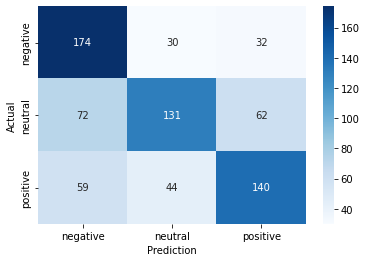

In [263]:
clf_metrics(y_test, predicted)

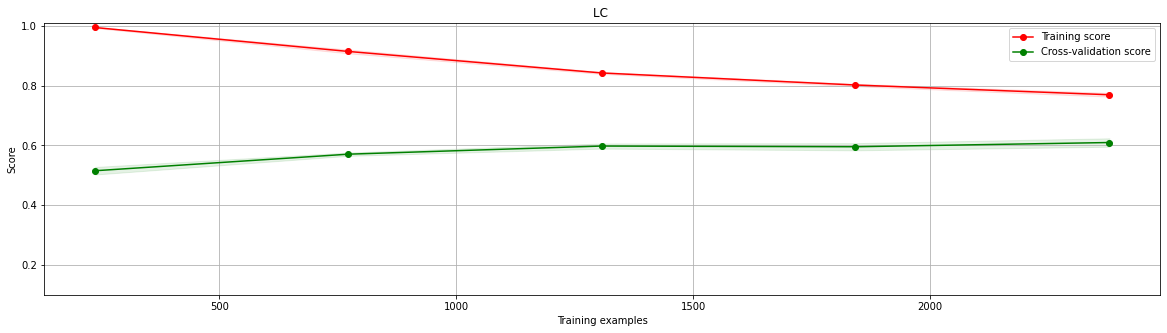

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

In [264]:
plot_learning_curve(
    text_clf, "LC ", X=X_train, y=y_train,ylim=(0.1, 1.01), cv=5, n_jobs=-1
)

# SVM Classification Performance against another topic

In [265]:
def load_data_formula_one():
  df_f1 = pd.read_csv("tweets_annotated.1650575029.formulaone.csv")
  df_f1 = prepare_text_df(df_f1)
  X_f1 = df_f1.lemmatized_tweet.values.reshape(-1,1)
  y_f1 = df_f1.sentiment.values.reshape(-1,1)
  X_f1_resampled, y_f1_resampled = random_under_sample(X_f1,y_f1)
  return pd.DataFrame ({ 'lemmatized_tweet': X_f1_resampled, 'sentiment': y_f1_resampled})

In [266]:
df_f1_resampled = load_data_formula_one()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


[('negative', 754), ('neutral', 754), ('positive', 754)]


In [267]:
predicted_f1 = text_clf.predict(df_f1_resampled.lemmatized_tweet)

              precision    recall  f1-score   support

    negative       0.46      0.79      0.58       754
     neutral       0.64      0.06      0.10       754
    positive       0.50      0.61      0.55       754

    accuracy                           0.48      2262
   macro avg       0.53      0.48      0.41      2262
weighted avg       0.53      0.48      0.41      2262



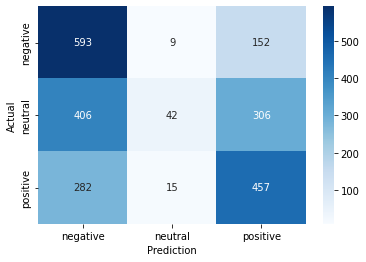

In [268]:
clf_metrics(df_f1_resampled.sentiment, predicted_f1)

# Vader

In [269]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [270]:
analyzer = SentimentIntensityAnalyzer()
def vader_sentiment(sentence):
  vs = analyzer.polarity_scores(sentence)
  comp = vs['compound']
  if comp > 0.05:
    return 'positive'
  elif comp < -0.05:
    return 'negative'
  else:
    return 'neutral'

In [271]:
vader_predicted = X_test.apply(vader_sentiment)

              precision    recall  f1-score   support

    negative       0.68      0.50      0.58       236
     neutral       0.59      0.40      0.48       265
    positive       0.48      0.77      0.59       243

    accuracy                           0.56       744
   macro avg       0.58      0.56      0.55       744
weighted avg       0.58      0.56      0.55       744



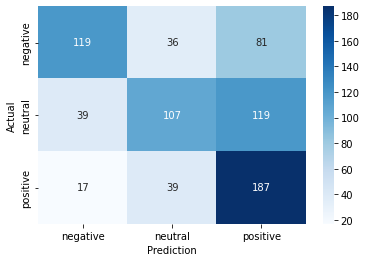

In [272]:
clf_metrics(y_test, vader_predicted)

In [273]:
len(X_test[(y_test == "neutral") & (vader_predicted == "positive")])

119

# Deep Neural Network Classifier

In [274]:
import numpy as np
import pandas as pd
import re
import gensim
from nltk.tokenize import TreebankWordTokenizer
from nltk.tokenize.treebank import TreebankWordDetokenizer
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [275]:
df_resampled = load_data_musk()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


[('negative', 1239), ('neutral', 1239), ('positive', 1239)]


In [276]:
def labels_categorical(data):
  labels = np.array(data)
  y = []
  for i in range(len(labels)):
      if labels[i] == 'neutral':
          y.append(0)
      if labels[i] == 'negative':
          y.append(1)
      if labels[i] == 'positive':
          y.append(2)
  y = np.array(y)
  labels = tf.keras.utils.to_categorical(y, 3, dtype="float32")
  del y
  return labels

In [277]:
labels = labels_categorical(df_resampled.sentiment)

In [278]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import regularizers

max_words = 500
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df_resampled.lemmatized_tweet)
sequences = tokenizer.texts_to_sequences(df_resampled.lemmatized_tweet)
tweets = pad_sequences(sequences, maxlen=max_len)
print(tweets)

[[  0   0   0 ...  23   1  16]
 [  0   0   0 ...  90 350 115]
 [  0   0   0 ... 222   2 125]
 ...
 [  0   0   0 ... 118 206 191]
 [  0   0   0 ...  65   2   1]
 [  0   0   0 ... 132 119 133]]


In [279]:
X_train, X_test, y_train, y_test = train_test_split(tweets, labels, test_size=0.3, random_state=32)

In [280]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2601, 200)
(1116, 200)
(2601, 3)
(1116, 3)


In [281]:
from keras.models import Sequential
from keras import layers
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.layers import Embedding
embedding_layer = Embedding(128, 16)

model1 = Sequential()
model1.add(layers.Embedding(max_words, 12))
model1.add(layers.LSTM(12,dropout=0.4, return_sequences=False))
model1.add(layers.Dense(3,activation='softmax'))

model1.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])

In [282]:
model1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, None, 12)          6000      
                                                                 
 lstm_4 (LSTM)               (None, 12)                1200      
                                                                 
 dense_4 (Dense)             (None, 3)                 39        
                                                                 
Total params: 7,239
Trainable params: 7,239
Non-trainable params: 0
_________________________________________________________________


In [283]:
#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint1 = ModelCheckpoint("best_model1.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model1.fit(X_train, y_train, epochs=20,validation_data=(X_test, y_test),callbacks=[checkpoint1])

Epoch 1/20
81/82 [============================>.] - ETA: 0s - loss: 1.0949 - accuracy: 0.3800
Epoch 1: val_accuracy improved from -inf to 0.43817, saving model to best_model1.hdf5
82/82 [==============================] - 4s 29ms/step - loss: 1.0948 - accuracy: 0.3806 - val_loss: 1.0861 - val_accuracy: 0.4382
Epoch 2/20
79/82 [===========================>..] - ETA: 0s - loss: 1.0614 - accuracy: 0.4553
Epoch 2: val_accuracy improved from 0.43817 to 0.46057, saving model to best_model1.hdf5
82/82 [==============================] - 1s 13ms/step - loss: 1.0608 - accuracy: 0.4564 - val_loss: 1.0414 - val_accuracy: 0.4606
Epoch 3/20
79/82 [===========================>..] - ETA: 0s - loss: 1.0051 - accuracy: 0.4937
Epoch 3: val_accuracy improved from 0.46057 to 0.48925, saving model to best_model1.hdf5
82/82 [==============================] - 1s 11ms/step - loss: 1.0044 - accuracy: 0.4952 - val_loss: 0.9975 - val_accuracy: 0.4892
Epoch 4/20
77/82 [===========================>..] - ETA: 0s - lo

In [284]:
import keras

best_model = keras.models.load_model("best_model1.hdf5")

In [285]:
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=2)
print('Model accuracy: ',test_acc)

35/35 - 1s - loss: 0.8999 - accuracy: 0.6147 - 560ms/epoch - 16ms/step
Model accuracy:  0.6146953701972961


In [286]:
predictions = best_model.predict(X_test)

              precision    recall  f1-score   support

           0       0.51      0.72      0.60       387
           1       0.67      0.55      0.60       357
           2       0.68      0.50      0.58       372

    accuracy                           0.59      1116
   macro avg       0.62      0.59      0.59      1116
weighted avg       0.62      0.59      0.59      1116



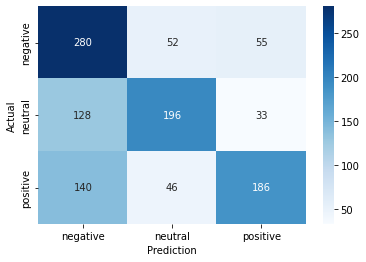

In [287]:
clf_metrics(y_test.argmax(axis=1), np.around(predictions, decimals=0).argmax(axis=1))

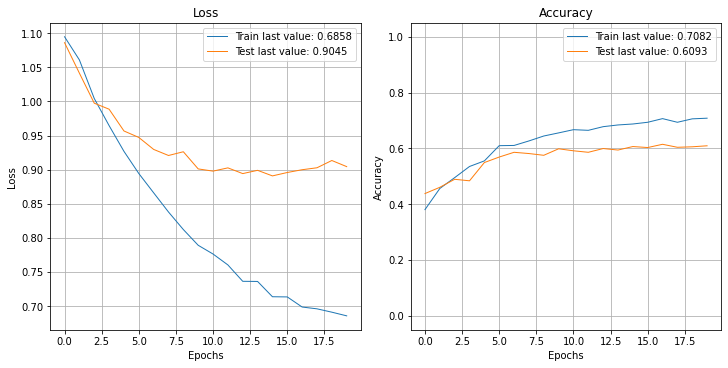

In [288]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history)
plot_history(history, path="standard.png")
plt.close()

# Visualisations

In [216]:
# df = pd.read_csv("tweets_annotated.1650577206.elonmusk.csv")
df = pd.read_csv("tweets_annotated.1650575029.formulaone.csv")

In [217]:
df.head()

,id,author_id,tweet,geo,lat,long,created_at,source,retweet_count,reply_count,like_count,quote_count,sentiment
0,1517234037592494080,1047566053482618881,At some point I can only conclude that people ...,None,59.37722,28.19028,2022-04-21 20:09:18+00:00,Twitter Web App,0,0,0,0,negative
1,1517234024212795392,847015407307378688,@tbablue1 @AnasSarwar @ScotTories what do thin...,None,10.58806,77.24779,2022-04-21 20:09:14+00:00,Twitter Web App,0,0,0,0,negative
2,1517234018277683200,2981572921,"@lexiegracew Idk if you use formula or not, bu...",None,39.78504,-85.76942,2022-04-21 20:09:13+00:00,Twitter for Android,0,0,0,0,negative
3,1517232519523012608,777523389120520192,Raising F1 budget cap would tilt playing field...,None,22.75218,72.68533,2022-04-21 20:03:16+00:00,WordPress.com,0,0,0,0,neutral
4,1517231268106321921,1439331707233177603,if you sat down and added up how much sturgeon...,None,45.53069,9.40531,2022-04-21 19:58:17+00:00,Twitter Web App,0,0,0,0,negative


In [218]:
df['created_at'] = pd.to_datetime(df['created_at'])

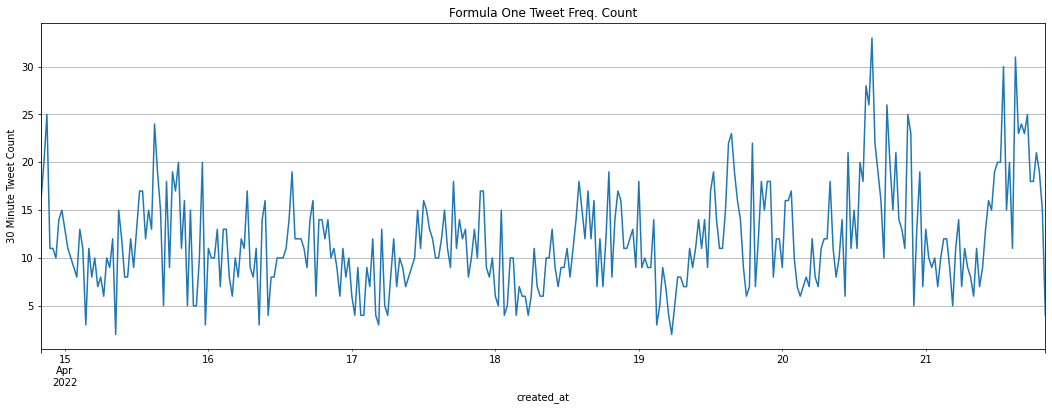

In [219]:
tweet_df_5min = df.groupby(pd.Grouper(key='created_at', freq='30Min', convention='start')).size()
tweet_df_5min.plot(figsize=(18,6))
plt.ylabel('30 Minute Tweet Count')
plt.title('Formula One Tweet Freq. Count')
plt.grid(True)

In [220]:
from wordcloud import WordCloud

In [221]:
def prep_text_for_wordcloud(df):
  df['cleaned_tweet'] = df['tweet'].str.replace('https\S+|http\S+|www.\S+|@.\S+|&amp;.\S+|<.*?>', '', case=False)
  df['cleaned_tweet'] = df['cleaned_tweet'].str.lower()
  df['cleaned_tweet'] = df['cleaned_tweet'].str.strip()
  df['normalized_tweet'] = df['cleaned_tweet'].str.translate(str.maketrans('', '', output))
  df['normalized_tweet'] = df['normalized_tweet'].apply(no_stopwords)
  return df

In [222]:
wordcloud_df = prep_text_for_wordcloud(df)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [223]:
def create_wordcloud(wc_title, series):
  wordcloud = WordCloud(width=800, height=400, margin=2).generate(' '.join(series))
  plt.figure(figsize=(10,10))
  plt.title(wc_title)
  plt.axis("off")
  plt.imshow(wordcloud)

In [224]:
hashtag_counts = df.tweet.str.extractall(r'(\#\w+)')[0].value_counts()

In [225]:
top_hashtags = hashtag_counts[hashtag_counts > 10]

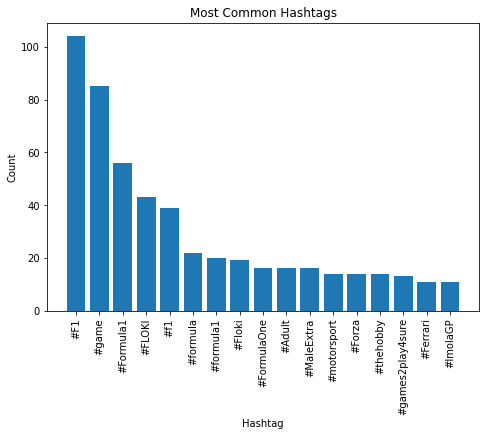

In [226]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
keys = top_hashtags.keys().to_list()
values = list(top_hashtags.array)
ax.bar(keys,values)
plt.title("Most Common Hashtags")
plt.xticks(rotation=90)
plt.xlabel("Hashtag")
plt.ylabel("Count")
plt.show()

In [227]:
positive_tweets = wordcloud_df[wordcloud_df["sentiment"] == "positive"]['normalized_tweet']
neutral_tweets = wordcloud_df[wordcloud_df["sentiment"] == "neutral"]['normalized_tweet']
negative_tweets = wordcloud_df[wordcloud_df["sentiment"] == "negative"]['normalized_tweet']
tweets_with_likes = wordcloud_df[wordcloud_df["like_count"] > 10]['normalized_tweet']
tweets_with_retweets = wordcloud_df[wordcloud_df["retweet_count"] > 5]['normalized_tweet']

In [228]:
len(tweets_with_retweets)

109

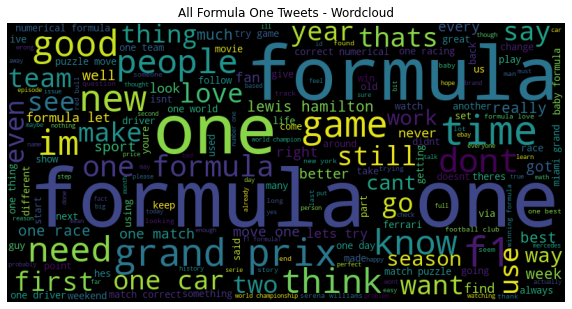

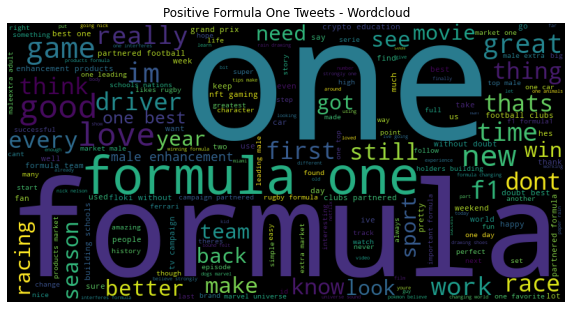

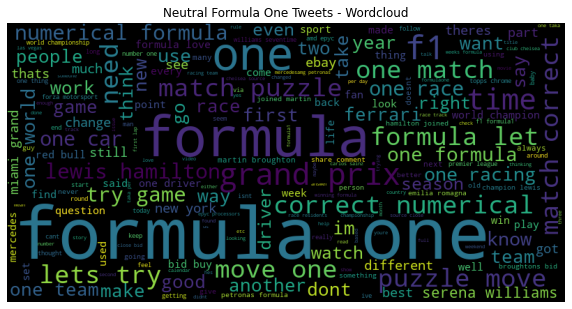

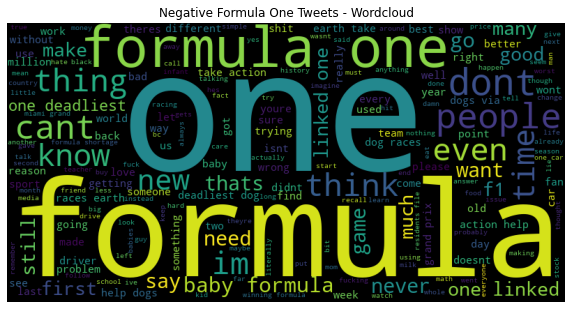

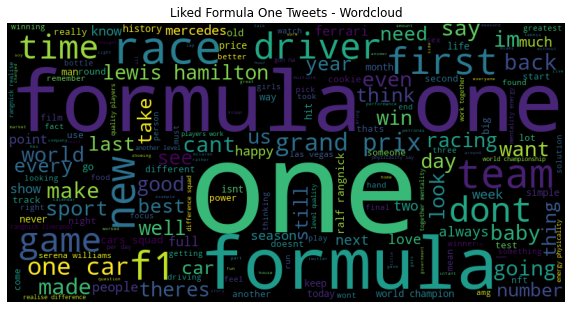

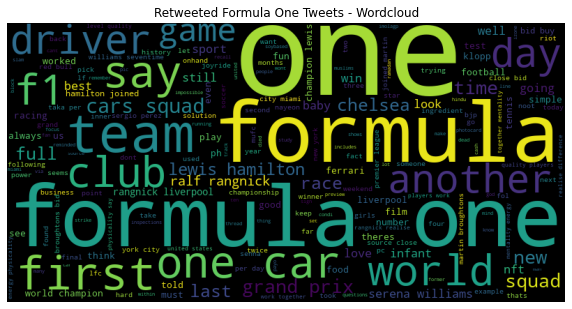

In [229]:
create_wordcloud("All Formula One Tweets - Wordcloud", wordcloud_df['normalized_tweet'])
create_wordcloud("Positive Formula One Tweets - Wordcloud",  positive_tweets)
create_wordcloud("Neutral Formula One Tweets - Wordcloud",  neutral_tweets)
create_wordcloud("Negative Formula One Tweets - Wordcloud",  negative_tweets)
create_wordcloud("Liked Formula One Tweets - Wordcloud",  tweets_with_likes)
create_wordcloud("Retweeted Formula One Tweets - Wordcloud",  tweets_with_retweets)